# Running experiments for our local calibration method

In [1]:
# importing generally used modules
import numpy as np

# for modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory

# data frames and statistics
from scipy import stats
import pandas as pd

# workspace management and counting running time
import os
import time

# graphics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# original directory
path_original = os.getcwd()

# our functions
# both quantile prediction models
from lcv.valid_pred_sets import LinearQuantileRegression
from lcv.valid_pred_sets import GradientBoostingQuantileRegression

# non-conformity scores
from lcv.scores import RegressionScore, QuantileScore

# locart method
from lcv.locart import LocartSplit

# locluster method
from lcv.locluster import KmeansSplit

# quantile split
from lcv.locart import QuantileSplit, LocalRegressionSplit

# figure path
images_dir = "figures"

## Simulated datasets
Now we will consider the same simulated datasets generated by Izbicki et.al (2022) to assess our hypothesis testing framework:

In [2]:
# importing simulated datasets module
from simulation import simulation

# shuffling and splitting in train, calibration and test sets
def split(X, y, test_size = 0.4, calibrate = True, random_seed = 1250):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size,
                                                        random_state = random_seed)
    if calibrate:
        X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.3,
                                                             random_state = random_seed)
        return {"X_train":X_train, "X_calib": X_calib, "X_test" : X_test, 
                "y_train" : y_train, "y_calib" : y_calib, "y_test": y_test}
    else:
        return{"X_train":X_train,"X_test" : X_test, 
                "y_train" : y_train,"y_test": y_test}

We will also need to compute conditional and real coverage. For that, we can compute coverage with the following function:

In [3]:
# methods to compute coverage
def real_coverage(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def locart_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        r[i] = np.unique(locart_model.predict_coverage(new_X, y_mat[i, :], marginal = False)) 
    return r

def uniform_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        # marginal
        r[i] = np.unique(locart_model.predict_coverage_uniform(new_X, y_mat[i, :], marginal = False))
        
    return r

# methods to compute interval length
def compute_interval_length(predictions):
    return(predictions[:, 1] - predictions[:, 0])

Testing our pruning approach versus other decision trees regarding conditional coverage:

In [4]:
def test_pruning(kind = "homoscedastic", 
           n = 10000,
           d = 20, 
           coef = 2,
           hetero_value = 1, 
           asym_value = 0.6,
           random_seed = 750,
           sig = 0.05,
           B_x = 4000,
           B_y = 1000,
           grid_min_samples = np.array([100, 500, 1000, 1500, 2000]),
           type_score = "regression",
           base_model = RandomForestRegressor,
           split_calib = False,
           **kwargs):
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = False)

    # coverage plot elements
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        # fitting pruning locart
        locart_prune = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_prune.fit(split_icp["X_train"], split_icp["y_train"])
        locart_prune.calib(split_icp["X_test"], split_icp["y_test"])

        # conditional and marginal coverage
        cond_locart_real = locart_coverage(locart_prune, X_test, y_mat)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        
        locart_interval_measures = compute_interval_length(np.array(locart_prune.predict(X_test)))
        locart_interval = np.mean(locart_interval_measures)

        # list of locart models 
        dist_list = [locart_ave_dist]
        med_coverage_list = [locart_med_cover]
        med_dist_list = [locart_med_dist]
        marg_coverage_list = [locart_ave_marginal_cov]
        int_length_list = [locart_interval]
        methods_names = ["Pruned tree"]

        for min_samples_leaf in grid_min_samples:
            locart = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart.fit(split_icp["X_train"], split_icp["y_train"])
            locart.calib(split_icp["X_test"], split_icp["y_test"], prune_tree = False, min_samples_leaf = min_samples_leaf)
            # computing coverage
            cond_coverage = locart_coverage(locart, X_test, y_mat)
            # computing metrics
            dist_list.append(np.mean(np.abs(cond_coverage - (1 - sig))))
            marg_coverage_list.append(np.mean(cond_coverage))
            int_length_list.append(np.mean(compute_interval_length(np.array(locart.predict(X_test)))))
            med_coverage_list.append(np.median(cond_coverage))
            med_dist_list.append(np.median(np.abs(cond_coverage - (1 - sig))))

            methods_names.append("leafs = " + str(min_samples_leaf))
        
        return pd.DataFrame(data = {"Methods":methods_names,
        "Average distance":dist_list,
        "Average marginal coverage": marg_coverage_list,
        "Average interval length": int_length_list,
        "Median conditional coverage": med_coverage_list,
        "Median distance": med_dist_list})

Analysing coverage for different distributions and CART models: 

Homoscedastic:

In [31]:
test_pruning()

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.949139,0.007975,0.949139,3.995778,0.951,0.006
1,leafs = 100,0.990445,0.040445,0.990445,3.898237,0.991,0.041
2,leafs = 500,0.961198,0.012869,0.961198,3.963129,0.963,0.013
3,leafs = 1000,0.952905,0.008397,0.952905,3.998215,0.954,0.007
4,leafs = 1500,0.950828,0.008020,0.950828,3.981904,0.952,0.006
5,leafs = 2000,0.953681,0.008825,0.953681,3.988737,0.955,0.008


Heteroscedastisc

In [32]:
test_pruning(kind = "heteroscedastic", hetero_value=0.15)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.974418,0.032130,0.974418,4.935242,0.984,0.036
1,leafs = 100,0.982507,0.034229,0.982507,4.785485,0.990,0.040
2,leafs = 500,0.975229,0.032094,0.975229,4.929516,0.984,0.036
3,leafs = 1000,0.960660,0.034701,0.960661,4.959803,0.971,0.038
4,leafs = 1500,0.962742,0.034092,0.962742,5.044207,0.973,0.038
5,leafs = 2000,0.955386,0.036974,0.955386,5.287756,0.965,0.040


Highly heteroscedastic:

In [33]:
test_pruning(kind = "heteroscedastic", hetero_value = 1.5)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.958950,0.025066,0.958950,6.824819,0.963,0.025
1,leafs = 100,0.984262,0.034471,0.984262,6.555294,0.987,0.037
2,leafs = 500,0.967131,0.024972,0.967131,6.787877,0.971,0.024
3,leafs = 1000,0.959009,0.025116,0.959009,6.791946,0.962,0.025
4,leafs = 1500,0.958704,0.025238,0.958704,6.869702,0.963,0.025
5,leafs = 2000,0.954329,0.026072,0.954329,6.889447,0.958,0.026


Asymmetric:

In [34]:
test_pruning(kind = "asymmetric", asym_value = 0.6)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.966765,0.026485,0.966765,6.928806,0.973,0.027
1,leafs = 100,0.971221,0.027413,0.971221,6.788606,0.977,0.028
2,leafs = 500,0.971555,0.027892,0.971556,7.020521,0.977,0.029
3,leafs = 1000,0.967439,0.026748,0.967439,6.966743,0.974,0.027
4,leafs = 1500,0.964251,0.026331,0.964251,7.145932,0.971,0.026
5,leafs = 2000,0.957838,0.026620,0.957838,7.310045,0.965,0.025


Highly asymmetric:

In [35]:
test_pruning(kind = "asymmetric", asym_value = 1.6)

KeyboardInterrupt: 

We also analyse the efficiency of splitting locart tree:

In [ ]:
test_pruning(split_calib = True)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.950320,0.009859,0.950320,4.002628
1,leafs = 100,0.928361,0.022044,0.928361,4.018390
2,leafs = 500,0.948185,0.009877,0.948185,3.973476
3,leafs = 1000,0.951646,0.009825,0.951646,3.956951
4,leafs = 1500,0.948069,0.009816,0.948069,3.962286
5,leafs = 2000,0.950452,0.009755,0.950452,4.008328


In [ ]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value=0.15)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.970672,0.030356,0.970672,5.584821
1,leafs = 100,0.984912,0.035577,0.984912,5.473791
2,leafs = 500,0.970193,0.030571,0.970193,5.573654
3,leafs = 1000,0.948784,0.036820,0.948784,5.882360
4,leafs = 1500,0.951207,0.035432,0.951207,5.834823
5,leafs = 2000,0.951506,0.035509,0.951506,5.855645


In [ ]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value = 1.5)

In [ ]:
test_pruning(split_calib = True, kind = "asymmetric", asym_value = 0.6)

In [ ]:
test_pruning(split_calib = True, kind = "asymmetric", asym_value = 1.6)

We will first compare our method to other conformal and non conformal methods using $S(\boldsymbol{x}, y) = |g(\boldsymbol{x}) - y|$ (Regression score) as our non conformity score:

### Regression Score

Here we will focus in comparing the regression conformal methods with our method on homoscedastisc, heteroscedastic and asymmetric data with noise. Our method returns diferent thresholds for $t(x)$ while the two commonly used weighted regression and regression split retuns a single threshold $t$. In order to compare these approaches, we define the following functions:

In [4]:
def compute_conformal_statistics(kind = "homoscedastic", 
           n = 20000,
           d = 20, 
           coef = 2,
           hetero_value = 1,
           asym_value = 0.6,
           t_degree = 4,
           random_seed = 1250, 
           sig = 0.05,
           alpha = 0.5,
           B_x = 4000,
           B_y = 1000,
           type_score = "regression",
           base_model = RandomForestRegressor,
           figname_tree = "locart_tree.pdf",
           only_locart = False,
           split_calib = False,
           plot_tree = True,
           n_estimators = 200,
           quantiles = [0.8, 0.85, 0.9, 0.95],
           random_states = [750, 85, 666, 69],
           prop_k = np.arange(2, 11),
           tune_k = True,
           criterion = "squared_error",
           max_depth = None,
           max_leaf_nodes = None,
           min_samples_leaf = 300,
           prune = True,
           **kwargs):
           
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5,calibrate = False)

    # coverage plot elements
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        if only_locart:
            # fitting locart
            locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
            locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
            max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)

            # conditional coverage and interval length
            pred_locart = np.array(locart_obj.predict(X_test, length = 2000))
            cond_locart_real =  real_coverage(pred_locart, y_mat)
            locart_interval_len = compute_interval_length(pred_locart)

            # several measures
            locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
            locart_med_cover = np.median(cond_locart_real)
            locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
            locart_ave_marginal_cov = np.mean(cond_locart_real)
            locart_interval = np.mean(locart_interval_len)

            all_results =  pd.DataFrame(data = {"Methods":["LOCART"],
                "Average distance":[locart_ave_dist],
                "Median conditional coverage":[locart_med_cover],
                "Median distance":[locart_med_dist],
                "Average marginal coverage":[locart_ave_marginal_cov],
                "Average interval length":[locart_interval]})

            # plotting boxplots
            # gathering all data into a data frame
            boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCART"], locart_interval_len.shape[0])),
                                            "Interval length": list(locart_interval_len),
                                            "Coverage": list(cond_locart_real)}), id_vars = ['Methods'], 
                                            value_vars = ['Interval length', 'Coverage'])

            plt.figure(figsize=(10, 6))
            sns.catplot(data = boxplot_data,
            y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
            plt.tight_layout()
            plt.show()

            # plotting tree to visualize partitions
            if plot_tree:
                plt.figure(figsize=(25, 20))
                locart_obj.plot_locart()
                plt.savefig(f"{images_dir}/{figname_tree}")
                plt.show()
            
            return [all_results, locart_obj]
        
        print("Fitting locluster")
        start_locluster = time.time()
        locluster_obj = KmeansSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locluster_obj.calib(split_icp["X_test"], split_icp["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)

        end_locluster = time.time()

        print("Computing metrics")
        start_locluster = time.time()
        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to compute metrics for Locluster: ", end_locluster)


        print("Fitting locart")
        start_loc = time.time()
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
        
        end_loc = time.time() - start_loc
        print("Time Elapsed to fit Locart: ", end_loc)

        print("Computing metrics")
        start_loc = time.time()
        # conditional coverage and interval length
        pred_locart = np.array(locart_obj.predict(X_test, length = 2000))
        cond_locart_real =  real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)
        end_loc = time.time() - start_loc
        print("Time Elapsed to compute metrics for Locart: ", end_loc)

        # fitting default regression split
        print("Fitting regression split")
        start_split = time.time()
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(split_icp["X_train"], split_icp["y_train"])
        icp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_split = time.time() - start_split
        print("Time Elapsed to fit regression split: ", end_split)

        print("Computing metrics")
        start_split = time.time()
        # icp real coverage and interval length
        icp_cond_r_real = real_coverage(icp.predict(X_test, significance = sig), y_mat)
        icp_interval_len = compute_interval_length(icp.predict(X_test, significance = sig))

        # computing icp measures
        icp_ave_dist = np.mean(np.abs(icp_cond_r_real - (1 - sig)))
        icp_ave_marginal_cov = np.mean(icp_cond_r_real)
        icp_med_cover = np.median(icp_cond_r_real)
        icp_med_dist = np.median(np.abs(icp_cond_r_real - (1 - sig)))
        icp_interval = np.mean(icp_interval_len)

        end_split = time.time() - start_split
        print("Time Elapsed to compute statistics for regression split: ", end_split)

        # fitting wighted regression split
        print("Fitting weighted regression split")
        start_weighted_split = time.time()
        wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
        wicp.fit(split_icp["X_train"], split_icp["y_train"])
        wicp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

        print("Computing metrics")
        start_weighted_split = time.time()
        # weighted icp real coverage and interval length
        wicp_cond_r_real = real_coverage(wicp.predict(X_test), y_mat)
        wicp_interval_len = compute_interval_length(wicp.predict(X_test))

        # computing wicp measures
        wicp_ave_dist = np.mean(np.abs(wicp_cond_r_real - (1 - sig)))
        wicp_ave_marginal_cov = np.mean(wicp_cond_r_real)
        wicp_med_cover = np.median(wicp_cond_r_real)
        wicp_med_dist = np.median(np.abs(wicp_cond_r_real - (1 - sig)))
        wicp_interval = np.mean(wicp_interval_len)

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)


        print("Fitting euclidean regression split")
        start_euclidean = time.time()
        # fitting uniform binning regression split
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])
        end_euclidean = time.time() - start_euclidean
        print("Time Elapsed to fit euclidean regression split: ", end_euclidean)

        # computing local coverage to uniform binning
        print("Computing metrics")
        start_euclidean = time.time()
        pred_uniform = np.array(locart_obj.predict(X_test, length = 2000, type_model = "euclidean"))
        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        end_euclidean = time.time() - start_euclidean
        print("Time Elapsed to compute statistics for euclidean regression split: ", end_euclidean)

        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "Regresion split", "Weighted regression split", "Euclidean regression split"],
        "Average distance":[locluster_ave_dist, locart_ave_dist,  icp_ave_dist, wicp_ave_dist, uniform_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, icp_med_cover, wicp_med_cover, uniform_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, icp_med_dist, wicp_med_dist, uniform_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, uniform_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, icp_interval, wicp_interval, uniform_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "Regresion split", 
        "Weighted regression split", "Euclidean regression split"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, icp_interval_len, wicp_interval_len, uniform_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, icp_cond_r_real, wicp_cond_r_real, uniform_cond_r_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        cqr = QuantileSplit(base_model, alpha = sig, **kwargs)
        cqr.fit(split_icp["X_train"], split_icp["y_train"])
        cqr.calibrate(split_icp["X_test"], split_icp["y_test"])

        # fitting locart
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model, 
        alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # fitting euclidean binning
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])

        # computing local coverage for uniform binning
        uniform_real = uniform_coverage(locart_obj, X_test, y_mat)

        # local coverage for quantile split
        quantile_r_real = real_coverage(cqr.predict(X_test), y_mat)

        # local coverage for locart
        locart_real = locart_coverage(locart_obj, X_test, y_mat)

        # computing average distance of coverage to 1 - alpha
        locart_ave_dist = np.mean(np.abs(locart_real - (1 - sig)))
        cqr_ave_dist = np.mean(np.abs(quantile_r_real - (1 - sig)))
        uniform_ave_dist = np.mean(np.abs(uniform_real - (1 - sig)))

        # computing average coverage
        locart_ave_cover = np.mean(locart_real)
        cqr_ave_cover = np.mean(quantile_r_real)
        uniform_ave_cover = np.mean(uniform_real)
        
        all_results = pd.DataFrame(data = {"Methods":["LOCART", "Quantile split", "Euclidean quantile split"],
        "Average coverage":[locart_ave_cover, cqr_ave_cover, uniform_ave_cover],
        "Average distance":[locart_ave_dist, cqr_ave_dist, uniform_ave_dist]})
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return [all_results, locart_obj]

In [6]:
list(np.repeat(["a", "b"], 3))

['a', 'a', 'a', 'b', 'b', 'b']

In [9]:
np.concatenate((np.array([1, 2]), np.array([1])))

array([1, 2, 1])

For now, we will fix $d = 20$, $\beta_1 = 2$ as some of the simulation parameters and vary the distribution of the data to compare our method to the usual split conformal methods, including the euclidean version of them:

### Normal Homoscedastic data:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  176.7729949951172
Fitting locart
Time Elapsed to fit Locart:  26.809206008911133
Computing metrics
Time Elapsed to compute metrics for Locart:  134.13420248031616
Fitting regression split
Time Elapsed to fit regression split:  25.964483737945557
Computing metrics
Time Elapsed to compute statistics for regression split:  0.7157096862792969
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  42.99194312095642
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6106226444244385
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.4951796531677246
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  130.9233434200287


<Figure size 720x432 with 0 Axes>

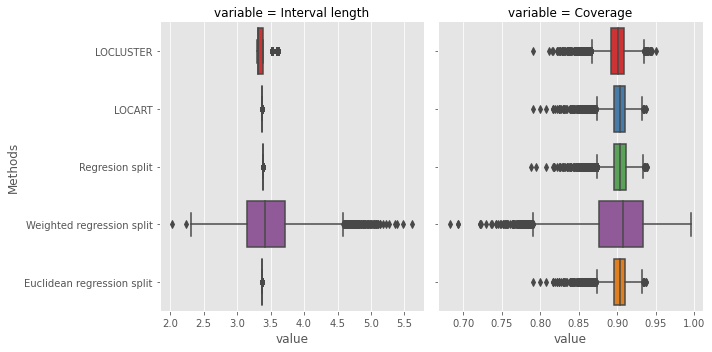

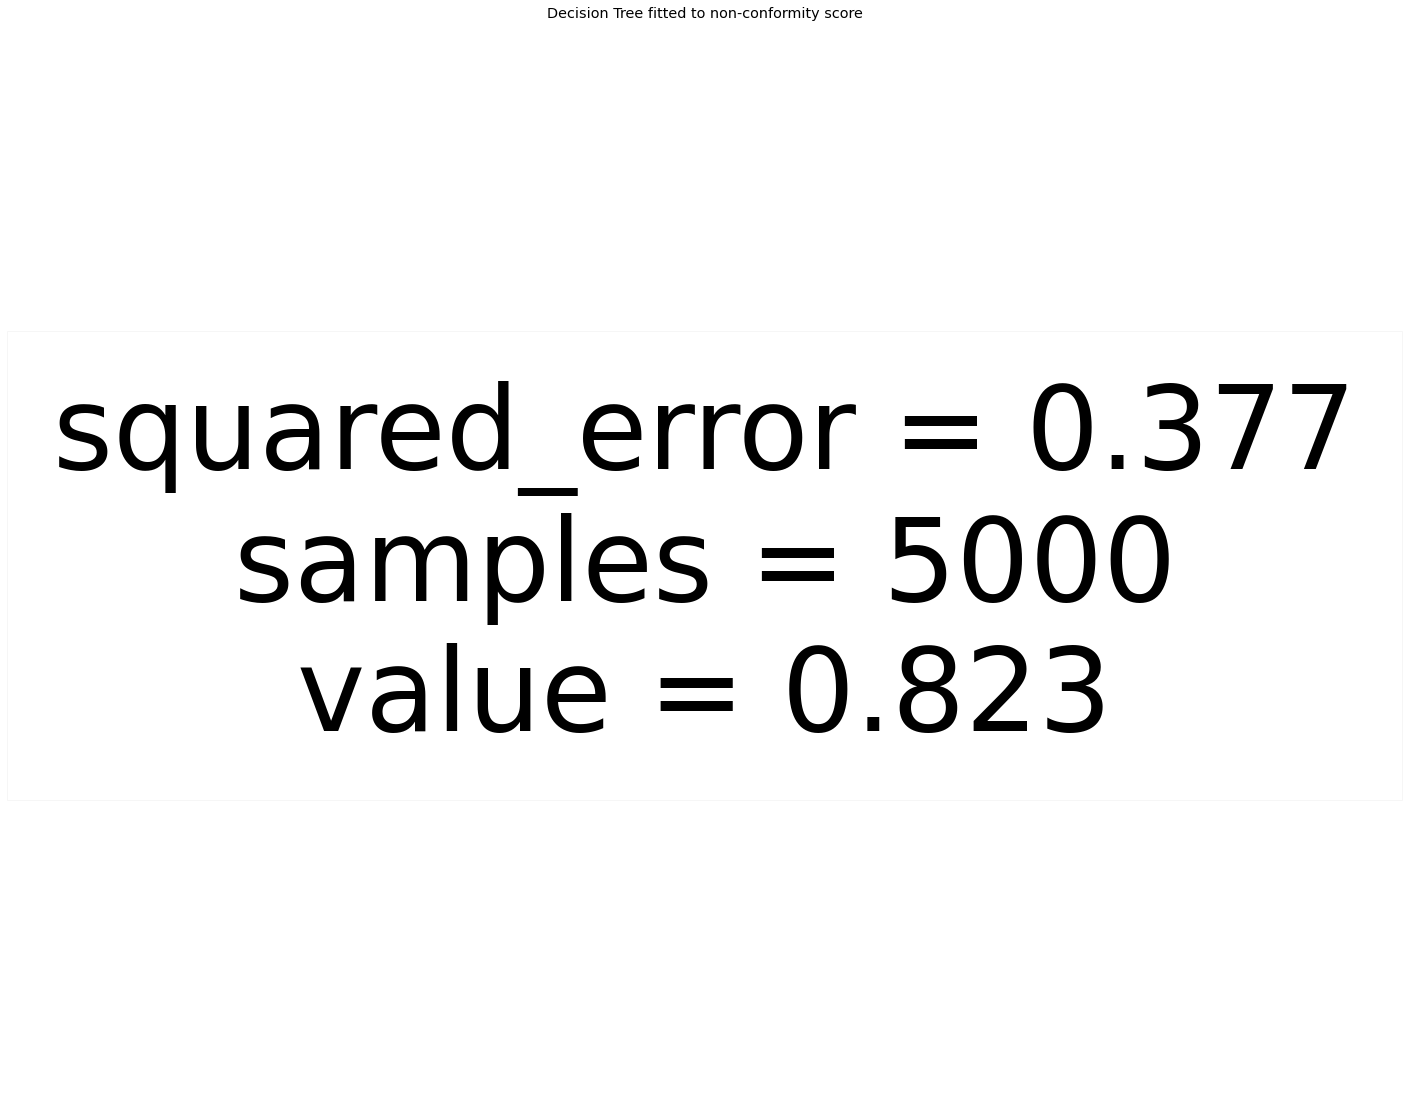

<Figure size 432x288 with 0 Axes>

In [5]:
locart_cov_values = compute_conformal_statistics(figname_tree = "locart_tree_homoscedastic_RF_d_20.pdf",
split_calib = True, B_x = 10000, sig  = 0.1)

In [6]:
locart_cov_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.010996,0.901,0.009,0.899700,3.351725
1,LOCART,0.010091,0.903,0.008,0.901741,3.368913
2,Regresion split,0.010405,0.904,0.009,0.902747,3.380437
3,Weighted regression split,0.034272,0.907,0.030,0.902276,3.449154
4,Euclidean regression split,0.010087,0.903,0.008,0.901710,3.368608


### Heteroscedastic data

Taking $\sigma = \sqrt{\gamma + \beta_1 \cdot |X_1|}$ with $\gamma = 0.25$

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  192.80952882766724
Fitting locart
Time Elapsed to fit Locart:  27.484757661819458
Computing metrics
Time Elapsed to compute metrics for Locart:  133.75703954696655
Fitting regression split
Time Elapsed to fit regression split:  26.480564832687378
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6826722621917725
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  39.75229024887085
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6667494773864746
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5190258026123047
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  132.27171087265015


<Figure size 720x432 with 0 Axes>

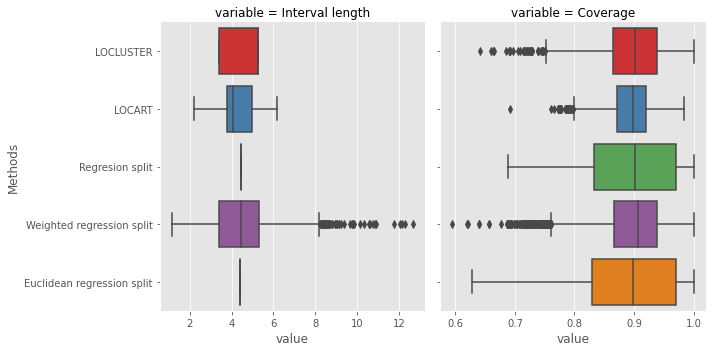

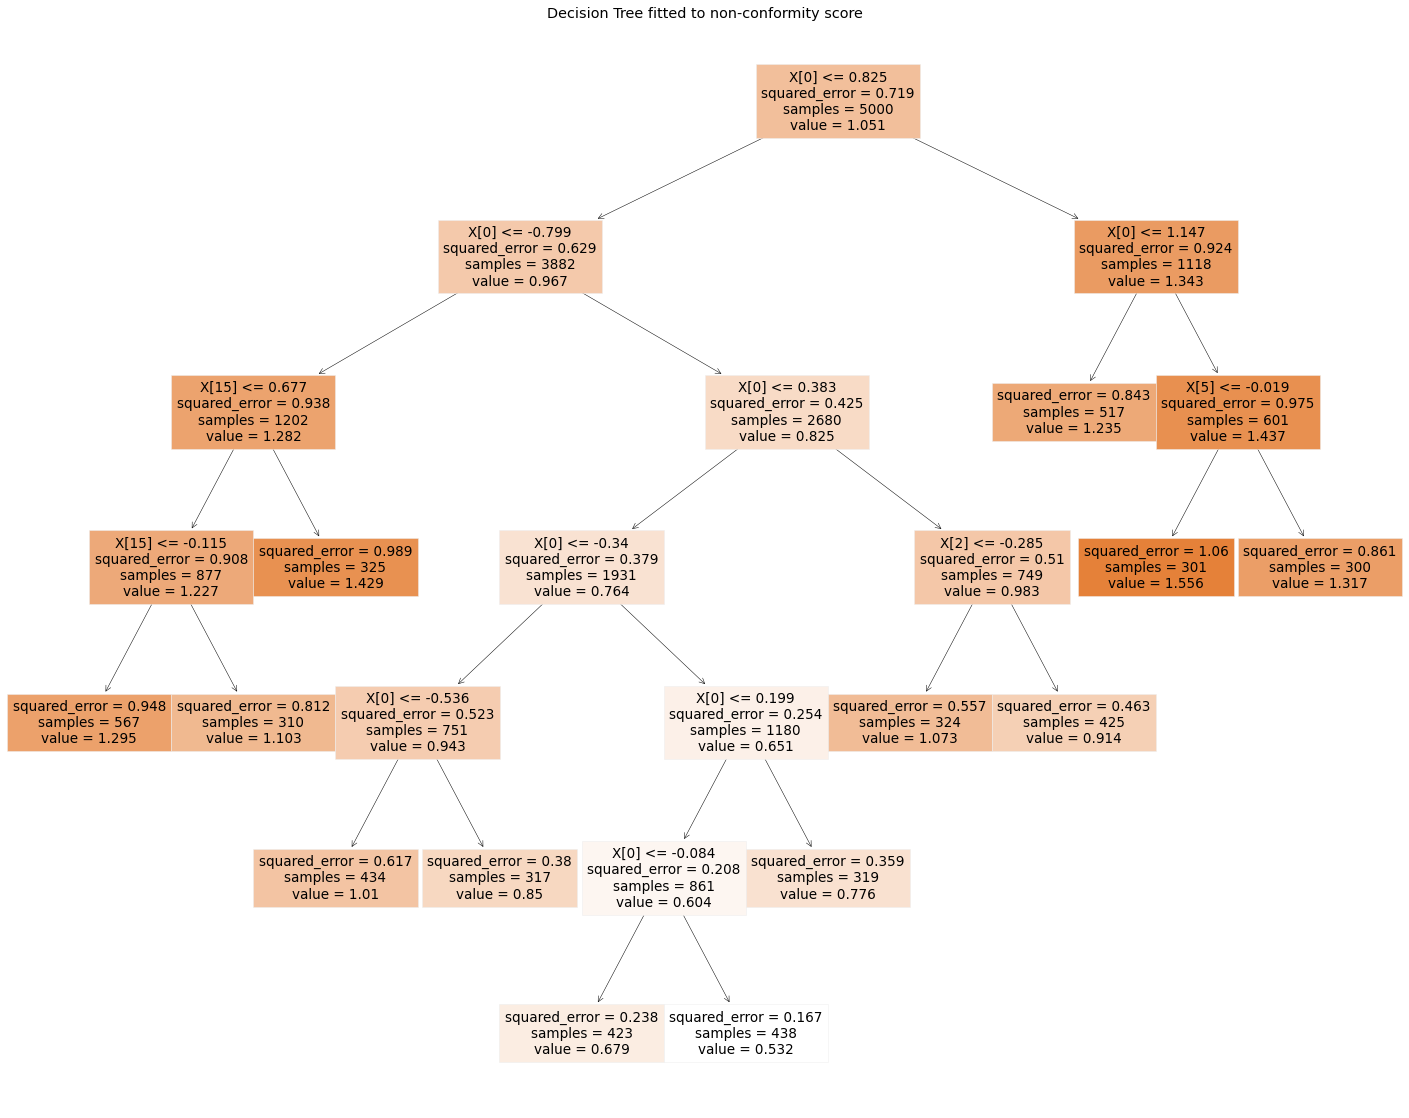

<Figure size 432x288 with 0 Axes>

In [7]:
values = compute_conformal_statistics(kind = "heteroscedastic", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
hetero_value = 0.25, sig = 0.1)

In [8]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.044328,0.901,0.037,0.900096,4.330064
1,LOCART,0.028291,0.898,0.024,0.896333,4.249391
2,Regresion split,0.065513,0.902,0.069,0.898714,4.435440
3,Weighted regression split,0.042556,0.906,0.036,0.898803,4.395616
4,Euclidean regression split,0.066544,0.899,0.070,0.896472,4.404774


### Asymmetric residuals (gamma)

Taking $\alpha = \beta = 1 + \eta \cdot |X_1|$ for $\eta = 0.7$:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  179.6047043800354
Fitting locart
Time Elapsed to fit Locart:  35.49583339691162
Computing metrics
Time Elapsed to compute metrics for Locart:  133.42214846611023
Fitting regression split
Time Elapsed to fit regression split:  34.988428354263306
Computing metrics
Time Elapsed to compute statistics for regression split:  0.7578887939453125
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  50.84445571899414
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.689192295074463
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.504042387008667
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  132.82601022720337


<Figure size 720x432 with 0 Axes>

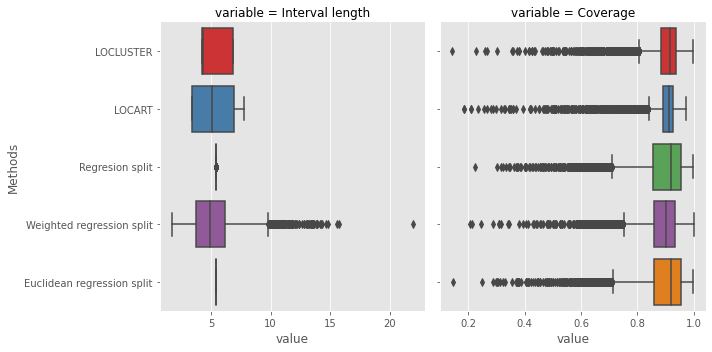

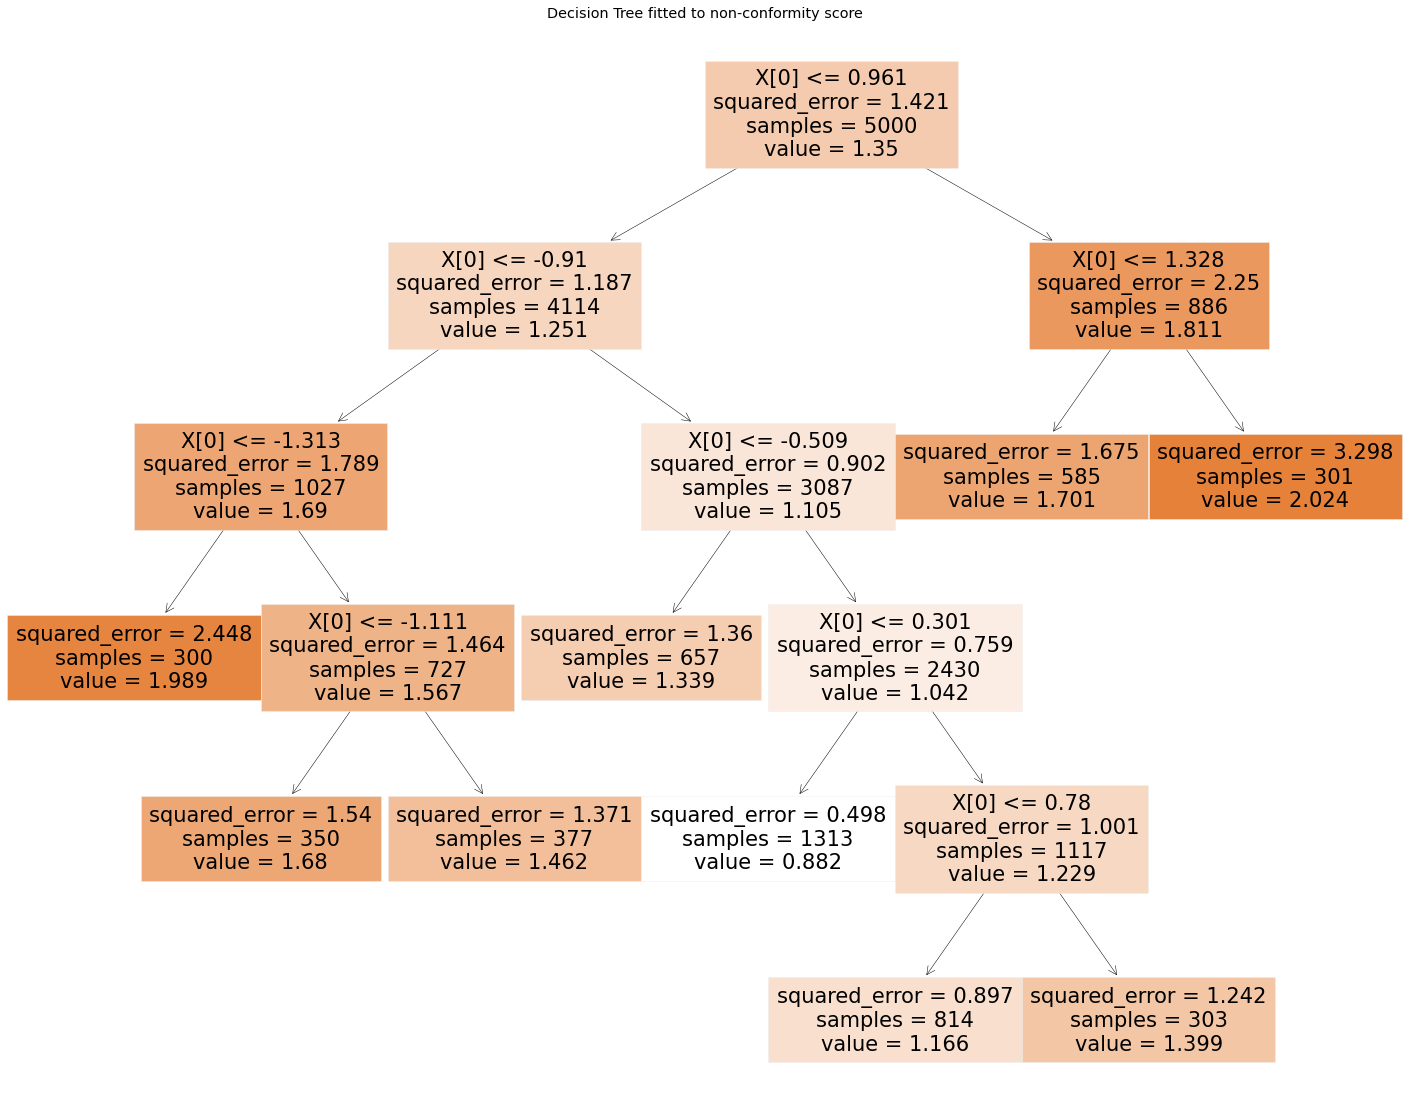

<Figure size 432x288 with 0 Axes>

In [9]:
values_asym = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_asymmetric_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
asym_value = 0.6, sig = 0.1)

In [10]:
values_asym[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.040223,0.914,0.030,0.900960,5.297029
1,LOCART,0.031398,0.912,0.021,0.899658,5.232998
2,Regresion split,0.062714,0.919,0.052,0.892412,5.398742
3,Weighted regression split,0.049499,0.902,0.036,0.886681,5.143279
4,Euclidean regression split,0.062442,0.920,0.052,0.893367,5.423250


Now taking $\eta = 1.5$:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  188.34587335586548
Fitting locart
Time Elapsed to fit Locart:  30.96412420272827
Computing metrics
Time Elapsed to compute metrics for Locart:  132.04880952835083
Fitting regression split
Time Elapsed to fit regression split:  29.41928791999817
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6900801658630371
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  44.29274559020996
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6077561378479004
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.4912383556365967
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  130.5129199028015


<Figure size 720x432 with 0 Axes>

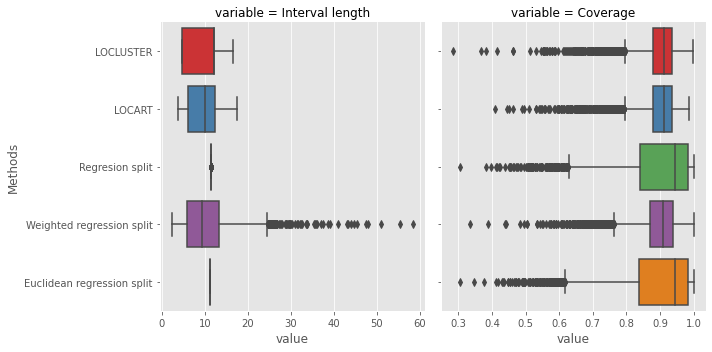

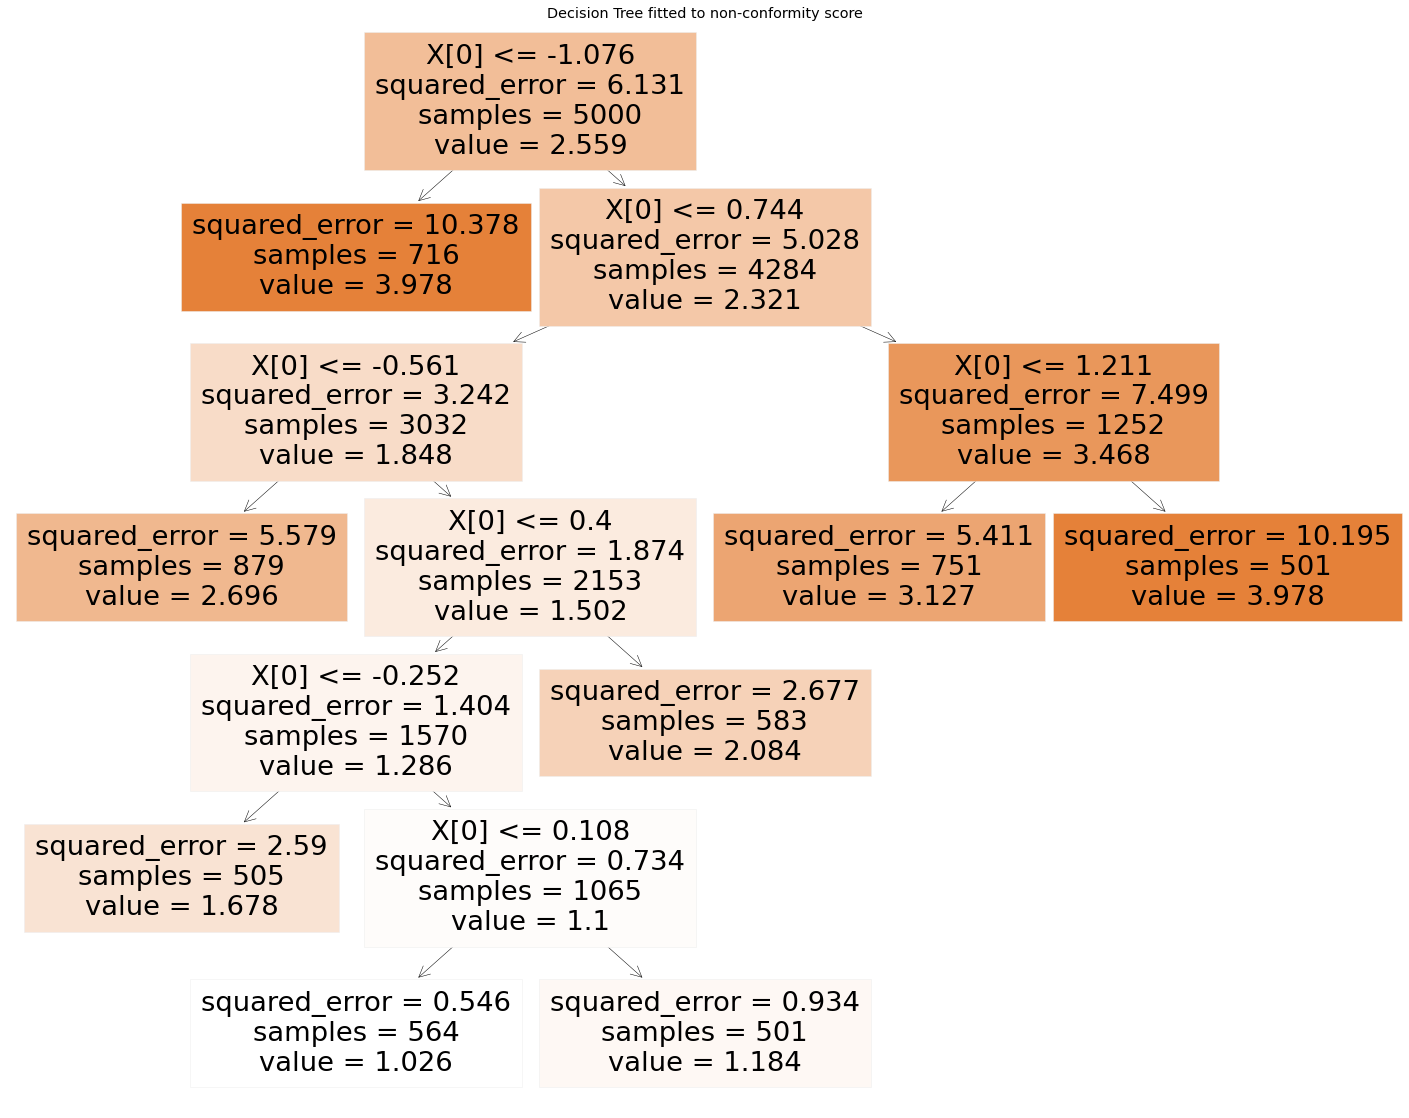

<Figure size 432x288 with 0 Axes>

In [11]:
values_asym = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True,
asym_value = 1.5, sig = 0.1, min_samples_leaf= 500)

In [12]:
values_asym[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.038159,0.911,0.030,0.901570,9.943189
1,LOCART,0.037735,0.911,0.030,0.899296,9.861343
2,Regresion split,0.084786,0.946,0.080,0.902463,11.337056
3,Weighted regression split,0.045492,0.909,0.037,0.897036,10.027528
4,Euclidean regression split,0.085953,0.946,0.080,0.900839,11.273026


### Homoscedastic t distribution

taking $\nu = 4$

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  159.44930362701416
Fitting locart
Time Elapsed to fit Locart:  28.101698398590088
Computing metrics
Time Elapsed to compute metrics for Locart:  129.2206630706787
Fitting regression split
Time Elapsed to fit regression split:  27.68313956260681
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6700022220611572
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  45.839871883392334
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6586523056030273
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.4936389923095703
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  126.6732726097107


<Figure size 720x432 with 0 Axes>

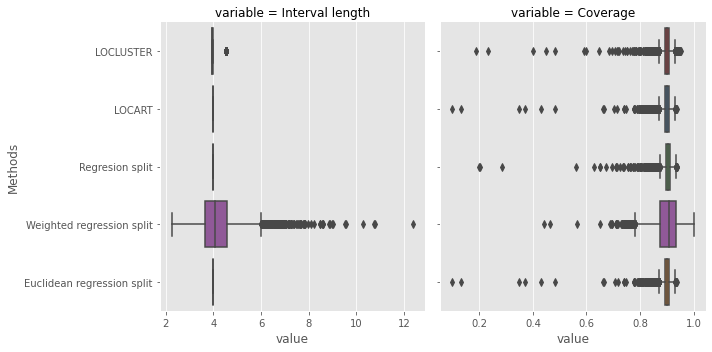

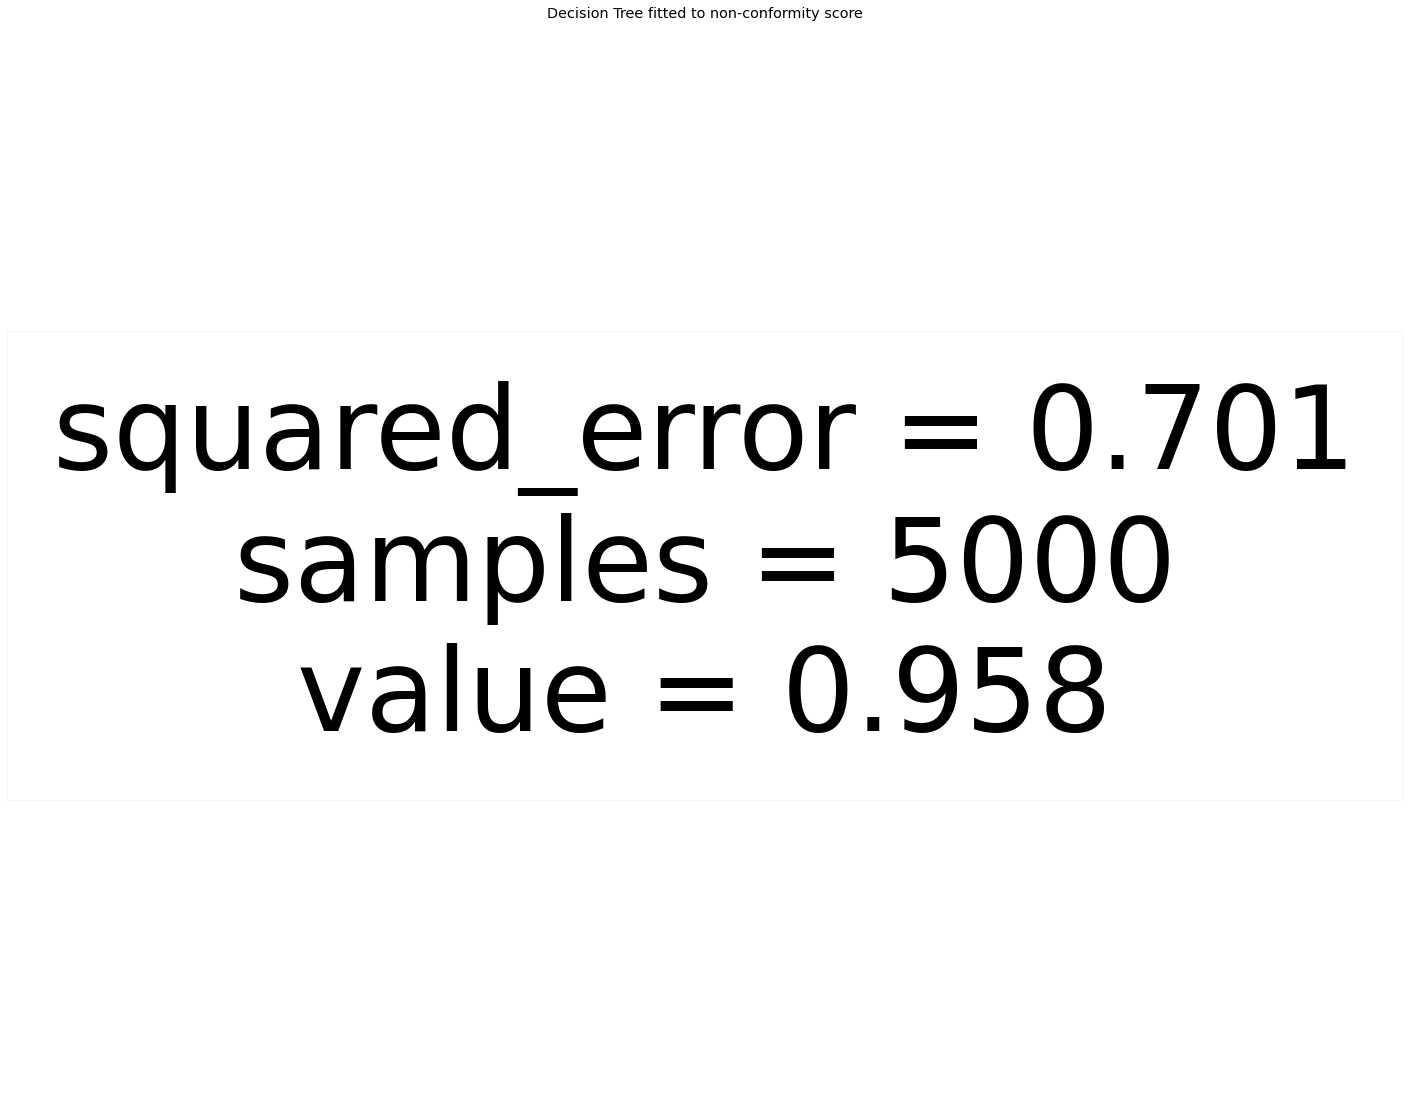

<Figure size 432x288 with 0 Axes>

In [13]:
values_t= compute_conformal_statistics(kind = "t_residuals", d = 20, t_degree= 6,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True, sig = 0.1)

In [14]:
values_t[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.010852,0.901,0.008,0.899057,3.969779
1,LOCART,0.010585,0.901,0.008,0.899037,3.968492
2,Regresion split,0.010784,0.903,0.008,0.901318,4.001277
3,Weighted regression split,0.036146,0.907,0.032,0.902004,4.170134
4,Euclidean regression split,0.010594,0.902,0.008,0.899371,3.973317


Decreasing $\nu$ to 1.5:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  157.90011978149414
Fitting locart
Time Elapsed to fit Locart:  37.209879636764526
Computing metrics
Time Elapsed to compute metrics for Locart:  129.44623684883118
Fitting regression split
Time Elapsed to fit regression split:  36.147057056427
Computing metrics
Time Elapsed to compute statistics for regression split:  0.7095532417297363
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  57.97927451133728
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.7920212745666504
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5498394966125488
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  133.5852997303009


<Figure size 720x432 with 0 Axes>

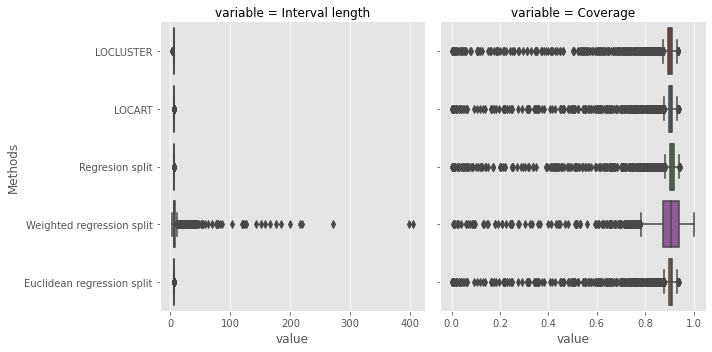

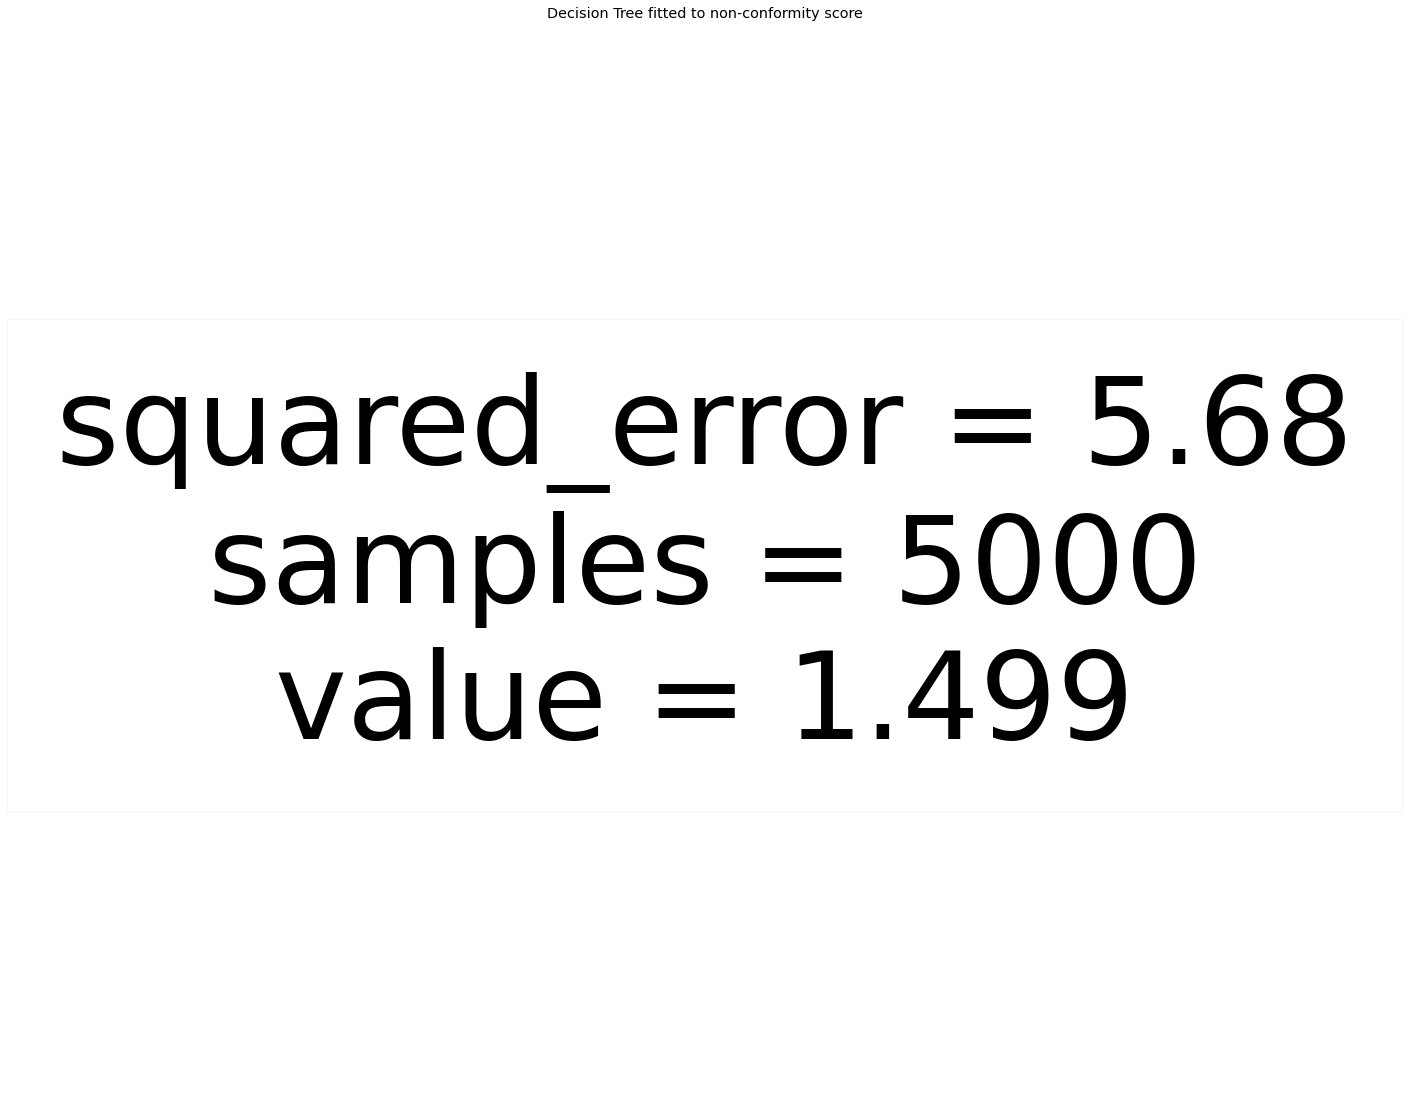

<Figure size 432x288 with 0 Axes>

In [15]:
values_t= compute_conformal_statistics(kind = "t_residuals", d = 20, t_degree= 2,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True, sig = 0.1)

In [16]:
values_t[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.018703,0.904,0.008,0.894121,6.111462
1,LOCART,0.018881,0.906,0.009,0.895825,6.170151
2,Regresion split,0.021677,0.911,0.013,0.900917,6.373932
3,Weighted regression split,0.041462,0.908,0.033,0.900227,7.526862
4,Euclidean regression split,0.018880,0.906,0.009,0.895790,6.169128
